# Analysis of asymmetries in HS

This notebook is used to create Figure 2B of the manuscript


In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest as multi
import random
import pickle as pickle
from aidhs.aidhs_cohort_hip import AidhsCohort, AidhsSubject
from aidhs.paths import BASE_PATH

In [5]:
hemis=['lh', 'rh']

#create cohort
cohort= AidhsCohort(hdf5_file_root='{site_code}_{group}_featurematrix_norm_avg.hdf5', dataset='dataset_C-P-DC_alltrain.csv')

#get feature list
features = cohort.full_feature_list

#get subjects 
subjects = cohort.get_subject_ids(lesional_only = False)
len(subjects)

363

In [6]:
base_features=[
    '.label-{}.curvature.sm1',
    '.label-{}.gauss-curv_filtered_sm1',
    '.label-{}.gyrification.sm1',
    '.label-{}.thickness.sm1',
    '.label-avg.hippunfold_volume',
    '.label-avg.hippunfold_volume_icvcorr',
    ]

features = ['.inter_z.asym.combat'+feature.format('avg') for feature in base_features]

In [7]:
features_title = {
                '.curvature' : 'mean\ncurvature',
                '.gauss-curv_filtered': 'intrinsic\ncurvature ',
                '.gyrification' : 'gyrification ',
                '.thickness' : 'thickness ',
                '.FS_volume' :'freesurfer volume ',
                '.hippunfold_volume' :'volume',
}

def return_features_title(feature):
    for feat in set(features_title):
        if feat in feature:
            return features_title[feat]

In [8]:
def is_nan(x):
    return (x != x)

ages = []

df=pd.DataFrame()
for subject in subjects:
    # create subject object
    subj = AidhsSubject(subject, cohort=cohort)
    group=subj.get_demographic_features("group")
    if group=='P':
        lesional_hemi = subj.get_demographic_features("Lesional hemi")
    elif group=='DC':
        lesional_hemi = random.choice(['lh','rh'])   #random choice
    else:
        lesional_hemi = random.choice(['lh','rh'])   #random choice
    for hemi in hemis:
        values={}
        #get demographic info 
        values['ID']=subj.subject_id
        values['group']=group
        values['hemi'] = hemi
        values['site'], values['age_scan'], values['sex'], values['mri_neg'], values['lobes']= subj.get_demographic_features(["Site","Age at preoperative", "Sex", "Ever reported MRI negative", "Lobes",])
        FS_id, FS_folder, hippunfold_ID, hippunfold_folder=subj.get_demographic_features(["Freesurfer_ids", "Freesurfer_folder", "Hippunfold_ids", "Hippunfold_folder"])
        if is_nan(lesional_hemi):
            values['lesional'] = np.nan
        elif hemi==lesional_hemi:
            values['lesional'] = 'ipsi'
        else:
            values['lesional'] = 'contra'
        #get features               
        for feature in features:
            vals = subj.load_feature_values(feature, hemi)
            if vals.sum()!=0:
                values[feature]=vals[0]
            else:
                pass 
        # save values for each subject in panda matrix
        df2 = pd.DataFrame([values])
        df = pd.concat([df,df2],ignore_index=True)


In [10]:
#load or save matrix
file = os.path.join(BASE_PATH, 'data_saved', 'matrix_patients_norm_avg_231211.csv')   
df.to_csv(file)
# df=pd.read_csv(file, header=0,encoding='unicode_escape', index_col=0)

In [11]:
df.head()

,ID,group,hemi,site,age_scan,sex,mri_neg,lobes,lesional,.inter_z.asym.combat.label-avg.curvature.sm1,.inter_z.asym.combat.label-avg.gauss-curv_filtered_sm1,.inter_z.asym.combat.label-avg.gyrification.sm1,.inter_z.asym.combat.label-avg.thickness.sm1,.inter_z.asym.combat.label-avg.hippunfold_volume,.inter_z.asym.combat.label-avg.hippunfold_volume_icvcorr
0,MELDH29P0001,P,lh,H29,43.0,0.0,0.0,temporal,ipsi,1.075214,0.791993,-2.343489,-1.593284,-2.960157,-2.849878
1,MELDH29P0001,P,rh,H29,43.0,0.0,0.0,temporal,contra,-1.075214,-0.791993,2.343489,1.593284,2.960157,2.849878
2,MELDH29P0002,P,lh,H29,26.0,1.0,0.0,temporal,ipsi,3.936709,1.051452,-4.644826,-3.218154,-6.832421,-6.619061
3,MELDH29P0002,P,rh,H29,26.0,1.0,0.0,temporal,contra,-3.936709,-1.051452,4.644826,3.218154,6.832421,6.619061
4,MELDH29P0003,P,lh,H29,20.0,0.0,0.0,temporal,ipsi,2.100872,2.124506,-5.028144,-1.681260,-6.367978,-6.201366


In [12]:
df.groupby(['group','site', 'hemi',])['ID'].count()

group  site  hemi
C      H1    lh      91
             rh      91
       H29   lh      30
             rh      30
DC     H1    lh      27
             rh      27
       H11   lh      33
             rh      33
       H16   lh      30
             rh      30
P      H1    lh      22
             rh      22
       H11   lh      72
             rh      72
       H16   lh      13
             rh      13
       H29   lh      45
             rh      45
Name: ID, dtype: int64

## Analysis characteristation HS

In [13]:
features=[
    #  '.inter_z.asym.combat.label-avg.hippunfold_volume_icvcorr',
    '.inter_z.asym.combat.label-avg.hippunfold_volume',
    '.inter_z.asym.combat.label-avg.thickness.sm1',
    '.inter_z.asym.combat.label-avg.gyrification.sm1',
    '.inter_z.asym.combat.label-avg.curvature.sm1',
    '.inter_z.asym.combat.label-avg.gauss-curv_filtered_sm1',
]

In [14]:
def apply_stat_test(vals_1, vals_2, pval_thresh=0.05):
    from scipy.stats import shapiro, ttest_ind, mannwhitneyu
    norm1 = shapiro(vals_1)[1]
    norm2 = shapiro(vals_2)[1]
    if (norm1 < pval_thresh) or (norm2 < pval_thresh):  # null hypothesis: x comes from a normal distribution
        print(f"Feature {feature} is not parametric, we use  Mann-Whitney U test")
        coef_tt = mannwhitneyu(vals_1, vals_2)
        # test='Mann-Whitney U'
        test=0
    else:
        print(f"Feature {feature} is parametric, we use Student T-test")
        coef_tt = ttest_ind(vals_1, vals_2, equal_var = False)
        # test = 'Welch T-test'
        test=1
    return coef_tt[0], coef_tt[1], test

.inter_z.asym.combat.label-avg.hippunfold_volume
P:[152],C:[121], DC:[90]
P:-5.2543745040893555,C:-0.0007564667030237615,DC:0.17912620306015015
Feature .inter_z.asym.combat.label-avg.hippunfold_volume is not parametric, we use  Mann-Whitney U test
Feature .inter_z.asym.combat.label-avg.hippunfold_volume is not parametric, we use  Mann-Whitney U test
Feature .inter_z.asym.combat.label-avg.hippunfold_volume is not parametric, we use  Mann-Whitney U test
.inter_z.asym.combat.label-avg.thickness.sm1
P:[152, 152],C:[121, 121], DC:[90, 90]
P:-2.394482374191284,C:0.028920212760567665,DC:0.0937892273068428
Feature .inter_z.asym.combat.label-avg.thickness.sm1 is parametric, we use Student T-test
Feature .inter_z.asym.combat.label-avg.thickness.sm1 is parametric, we use Student T-test
Feature .inter_z.asym.combat.label-avg.thickness.sm1 is parametric, we use Student T-test
.inter_z.asym.combat.label-avg.gyrification.sm1
P:[152, 152, 152],C:[121, 121, 121], DC:[90, 90, 90]
P:-4.093990325927734,C:

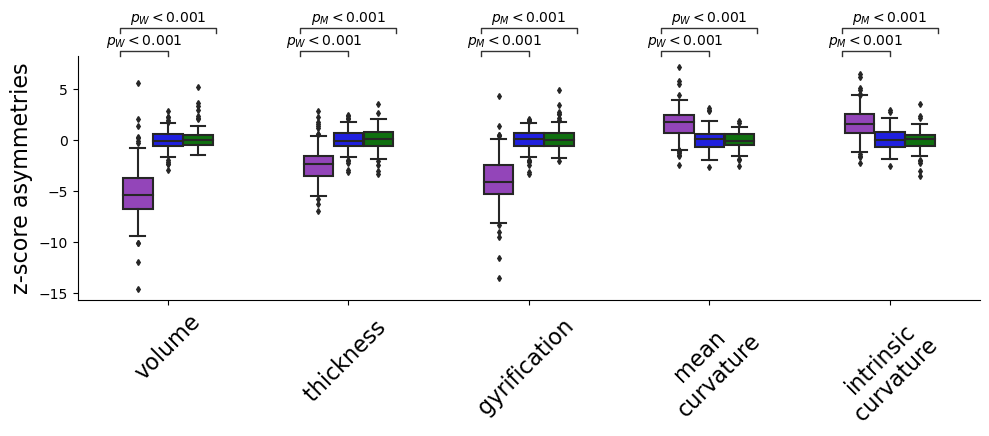

In [16]:
# plot features distribution in boxplots for ipsilateral HS, healthy controls and disease controls

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import numpy as np
from sklearn.metrics import auc, roc_curve, roc_auc_score

sub_features = features


ort='v'
pal={'P':'darkorchid', 'C':'blue', 'DC':'green'}

dict_significance=[[0.05, "*"], [1, 'ns']]

fig,ax = plt.subplots(figsize=(10,4))

subdf=df[(df['lesional']=='ipsi')].copy()
subdf.reset_index(drop=True, inplace=True)

subdf_pivot = subdf.melt(['ID','group','hemi','site','age_scan','sex','mri_neg','lobes','lesional'], var_name='feature',  value_name='vals')


sns.boxplot(x='feature', y='vals', data=subdf_pivot, hue='group', orient=ort, order=sub_features, palette=pal,
                saturation=0.75, width=0.5, dodge=True, fliersize=3, linewidth=None, whis=1)
           

ax.set_ylabel('z-score asymmetries', fontsize=16)
ax.set_xlabel('', fontsize=15)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticklabels([return_features_title(feature) for feature in sub_features], fontsize=16, rotation=45)

plt.tight_layout()

#compute stats and add to figure
matrix_tests = np.zeros((len(sub_features),3))
matrix_coefs= np.zeros((len(sub_features),3))
matrix_pvals= np.zeros((len(sub_features),3))

num_P=[]
num_C=[]
num_DC=[]
subsubdf={}

for i,feature in enumerate(sub_features):
    print(feature)
    subsubdf[i] = subdf.dropna(subset=[feature])

    #find array per group
    set1=subsubdf[i][subsubdf[i]['group']=='P'][feature]
    set2=subsubdf[i][subsubdf[i]['group']=='C'][feature]
    set3=subsubdf[i][subsubdf[i]['group']=='DC'][feature]
    
    #find number subjects per group
    num_P.append(len(set1))
    num_C.append(len(set2))
    num_DC.append(len(set3))

    print(f'P:{num_P},C:{num_C}, DC:{num_DC}')
    print(f'P:{set1.mean()},C:{set2.mean()},DC:{set3.mean()}')

    #compute stats
    stat, p, test = apply_stat_test(set1, set2)
    matrix_coefs[i,0]=stat
    matrix_pvals[i,0]=p
    matrix_tests[i,0]=test
    stat, p, test = apply_stat_test(set1, set3)
    matrix_coefs[i,1]=stat
    matrix_pvals[i,1]=p
    matrix_tests[i,1]=test
    stat, p, test = apply_stat_test(set2, set3)
    matrix_coefs[i,2]=stat
    matrix_pvals[i,2]=p
    matrix_tests[i,2]=test

#correct for multiple comparison
matrix_pvals_cor = (multi.multipletests(matrix_pvals.flatten(), alpha=0.05, method='holm')[1]).reshape((len(sub_features),3))

from statannot import add_stat_annotation

for i,feature in enumerate(sub_features):
    print(feature)
    #set number of subjects as ticks and initialise annotstats  
    box_pairs = []
    pvalues = []
    tests = []
    for p, pair in enumerate([["P","C"],["P","DC"],["C","DC"]]):
        if matrix_pvals_cor[i,p]<0.05:
            box_pairs.append(((feature,pair[0]), (feature,pair[1])))
            pvalues.append(matrix_pvals_cor[i,p])  
            tests.append(matrix_tests[i,p])  

    #add annotations about stats and significance
    print(box_pairs)
    print(pvalues)
    tests = ['M' if test == 0 else 'W' for test in tests]
    pvalues_annot = [ f'$p_{test}<0.001$' if pval<0.001 else f'$p_{test}={round(pval,3)}$' for (pval,test) in zip(pvalues,tests)]
    test_results = add_stat_annotation(ax, data=subdf_pivot, x='feature', y='vals', hue='group',
                                        box_pairs=box_pairs,
                                #    test='t-test_ind', text_format='star',
                                        perform_stat_test = False, pvalues=pvalues,
                                        text_annot_custom=pvalues_annot,
                                        # pvalue_thresholds=dict_significance, 
                                        line_offset_to_box=0.3, line_offset=False, line_height=0.02, text_offset=1, color='0.2', linewidth=1,
                                        loc='outside', verbose=2, fontsize=10)    
plt.legend([],[], frameon=False)


fig.savefig(os.path.join(BASE_PATH, 'images', f'characterisation_features_boxplot_asymzscore_noicv.png'), dpi=96, transparent =True,  bbox_inches = 'tight' )    

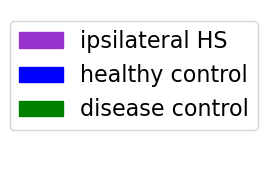

In [17]:
#plot labels
import matplotlib.patches as mpatches   
fig, ax = plt.subplots(figsize=(3,2))
patches=[mpatches.Patch(color='darkorchid', label='ipsilateral HS'),
         mpatches.Patch(color='blue', label='healthy control'),
         mpatches.Patch(color='green', label='disease control')]

#add legend in specific order
ax.legend(handles=patches, handletextpad=0.75, loc='best', fontsize=16)
ax.axis('off')
fig.savefig(os.path.join(BASE_PATH, 'images', f'legend_characterisation_features.png') )       

### Find threshold that predict right or left HS for each feature

.inter_z.asym.combat.label-avg.hippunfold_volume
lh
best threshold auc: 0.37
threshold on z-score asymmetry to predict HS: -1.899999976158142 

rh
best threshold auc: 0.93
threshold on z-score asymmetry to predict HS: -3.2699999809265137 

.inter_z.asym.combat.label-avg.thickness.sm1
lh
best threshold auc: 0.63
threshold on z-score asymmetry to predict HS: -1.7400000095367432 

rh
best threshold auc: 0.28
threshold on z-score asymmetry to predict HS: -0.6899999976158142 

.inter_z.asym.combat.label-avg.gyrification.sm1
lh
best threshold auc: 0.39
threshold on z-score asymmetry to predict HS: -1.8899999856948853 

rh
best threshold auc: 0.32
threshold on z-score asymmetry to predict HS: -1.3600000143051147 

.inter_z.asym.combat.label-avg.curvature.sm1
lh
best threshold auc: 0.37
threshold on z-score asymmetry to predict HS: 0.7099999785423279 

rh
best threshold auc: 0.39
threshold on z-score asymmetry to predict HS: 0.6700000166893005 

.inter_z.asym.combat.label-avg.gauss-curv_filter

<Figure size 640x480 with 0 Axes>

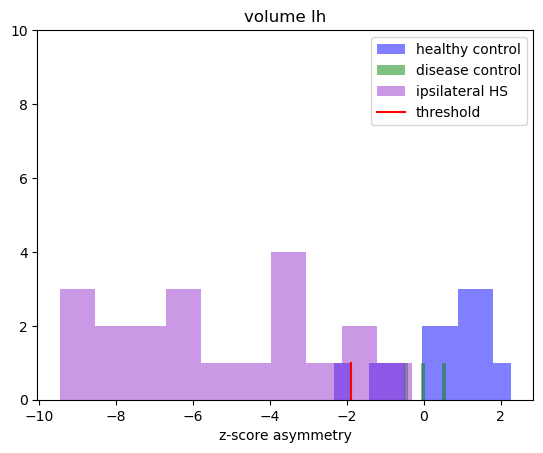

<Figure size 640x480 with 0 Axes>

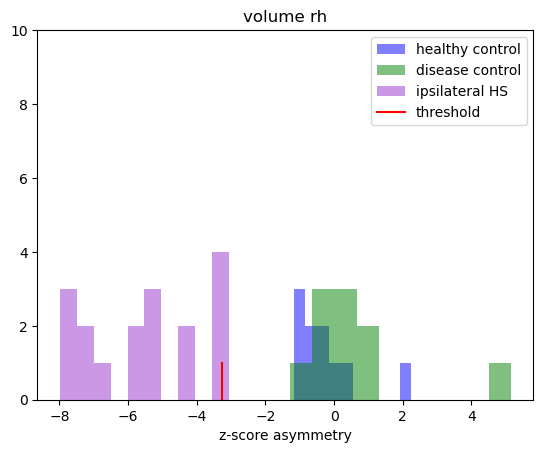

<Figure size 640x480 with 0 Axes>

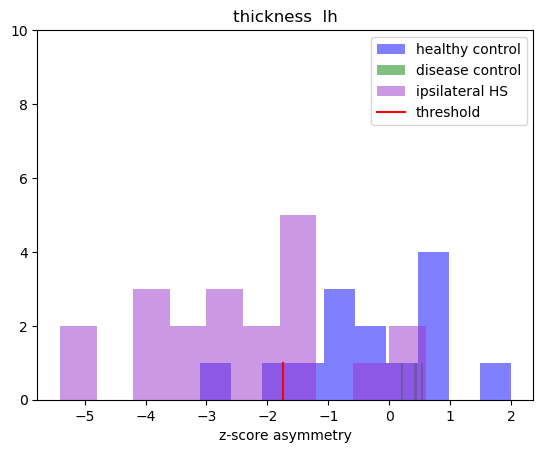

<Figure size 640x480 with 0 Axes>

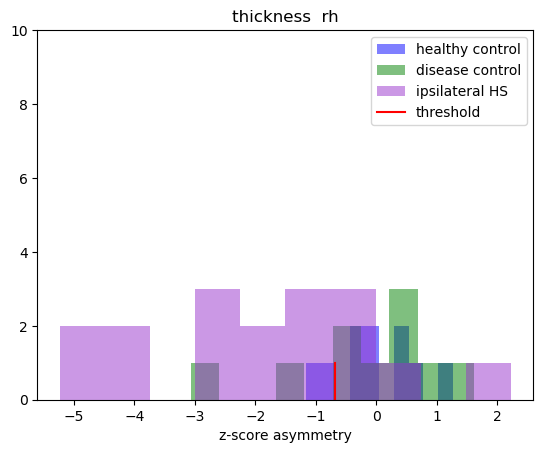

<Figure size 640x480 with 0 Axes>

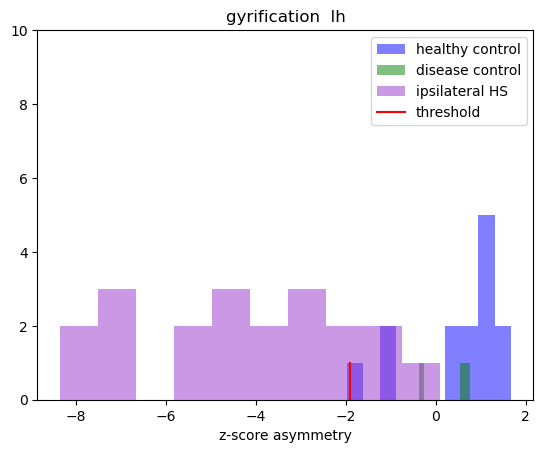

<Figure size 640x480 with 0 Axes>

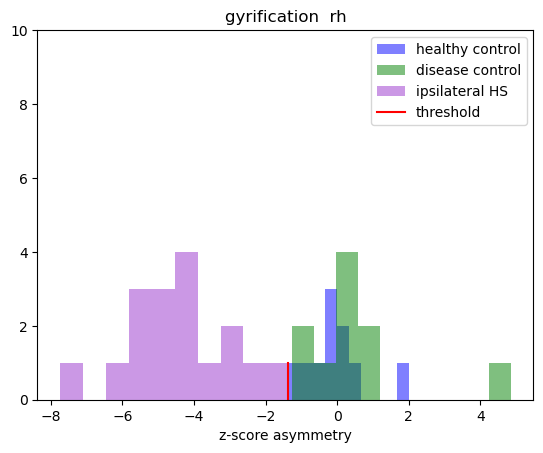

<Figure size 640x480 with 0 Axes>

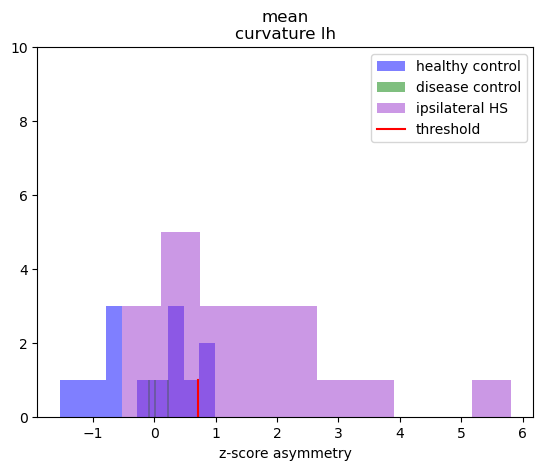

<Figure size 640x480 with 0 Axes>

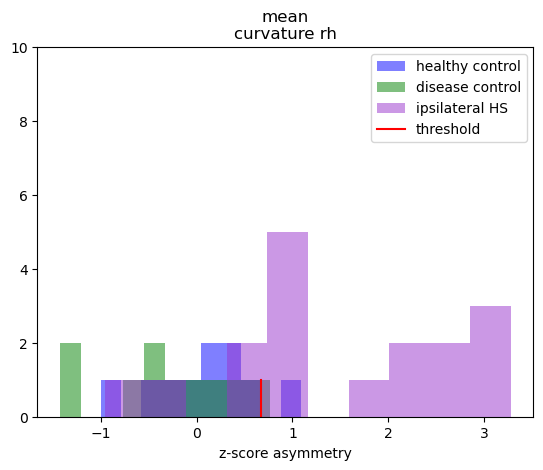

<Figure size 640x480 with 0 Axes>

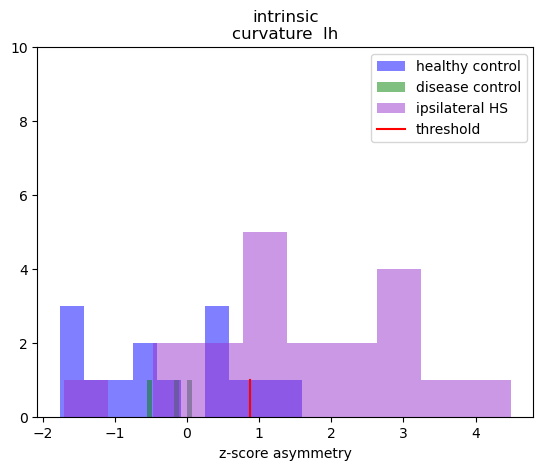

<Figure size 640x480 with 0 Axes>

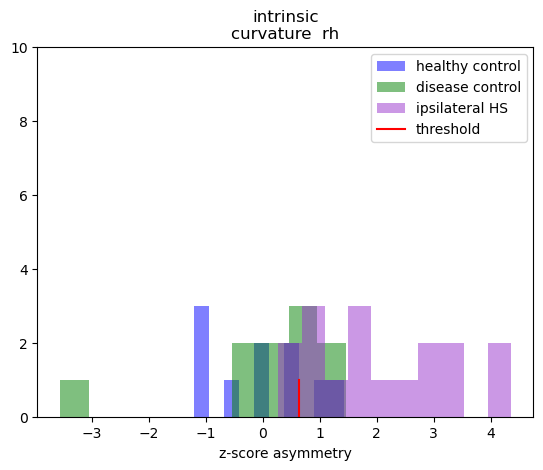

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder

sub_features = features

pal={'P':'darkorchid', 'C':'blue', 'DC':'green'}
group_title={'P':'ipsilateral HS', 'C': 'healthy control', 'DC':'disease control'}

abnormality_thresholds = {}
for feature in sub_features:
    print(feature)
    abnormality_thresholds[feature] = {}
    for hemi in ['lh','rh']:
        print(hemi)
        subdf = df[(df['lesional']=='ipsi') & (df['hemi']==hemi)].dropna(subset=feature)
        
        plt.figure()

        # select input
        X = subdf[[feature, 'group']]

        # select classe
        Y = (subdf['group']=='P')
        le = LabelEncoder().fit(Y)
        Y = le.transform(Y)

        # create train/test split of 40:60
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
        x_train_array = np.array(x_train[feature]).reshape(-1,1)
        x_test_array = np.array(x_test[feature]).reshape(-1,1)

        # initialise logistic regression model
        logistic = LogisticRegression() 
        model = logistic.fit(x_train_array, y_train)

        # predict probability 
        y_predict_prob = model.predict_proba(x_test_array)

        # calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_predict_prob[:,1])

        # find the threshold that predict patients
        J = tpr - fpr
        best_threshold = thresholds[np.argmax(J)]
        print(f'best threshold auc: {round(best_threshold,2)}')
        
        # #plot probabilities and color by group 
        # for group in ['C','DC','P']:
        #     mask = (x_test['group']==group)
        #     color = pal[group]
        #     plt.hist(y_predict_prob[mask,1], color=color, alpha=0.5, label=group)
        # plt.plot([best_threshold,best_threshold],[0,1], color='red', label='threshold')
        # plt.xlabel('predicted probability')
        # plt.title(return_features_title(feature))
        
        # sort the probabilities
        index = np.argsort(y_predict_prob[:,1])
        # find minimum value of the one predicted ipsi
        thresh = x_test_array[index,0][y_predict_prob[:,1][index]>best_threshold][0]
        abnormality_thresholds[feature][hemi]=thresh

        plt.figure()
        for group in ['C','DC','P']:
            mask = (x_test['group']==group)
            color = pal[group]
            plt.hist(x_test_array[mask], color=color, alpha=0.5, label=group_title[group])
        plt.plot([thresh,thresh],[0,1], color='red', label='threshold')
        plt.title(return_features_title(feature)+' '+hemi)
        plt.xlabel('z-score asymmetry')
        plt.ylim(0,10)
        plt.legend()
        print(f'threshold on z-score asymmetry to predict HS: {round(thresh,2)} \n')

# save abnormality thresholds
filename = os.path.join(BASE_PATH, 'data_saved', 'asymmetries_abnormality_thresholds_noicv.pkl' ) 
with open(filename, 'wb') as handle:
    pickle.dump(abnormality_thresholds, handle, protocol=pickle.HIGHEST_PROTOCOL)
